In [1]:
from mongo_connection import Mongo_connection
import numpy as np
import pandas as pd
import itertools
import pair_transition_analysis
import granger_causation_test
from matplotlib import pyplot as plt
from collections import defaultdict
import roi_config
import fixation
import hypothesis_testing
import bulk_run
import anova
import re
import utils

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 52 documents.


In [72]:
mongo = Mongo_connection()
mongo.connect()

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 50 documents.


In [4]:
utils.roi_config.encode_table

{'rpmleft': 'R', 'asi': 'S', 'alt': 'A', 'runway': 'X', 'unknown': 'Z'}

In [5]:
documents = mongo.find({})
lst_id = []
lst_transition = []
lst_rating = []
lst_group = []
for document in documents:
    print("trial: {}, group: {}, pID: {}".format(document["trial"], document["group"], document["pID"]))

    d_data = document["data"]
    df_data = pd.DataFrame(d_data)
    df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
    transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")
    lst_id.append(document["pID"])
    lst_transition.append(transitions)
    lst_rating.append(document["rating"])
    lst_group.append(document["group"])
    
    print(transitions)

trial: 1, group: 2, pID: 001
XZXAXZAXSXAXSAXSZSAXZAXAXAZSXASXAZXZAZXSXSASXSXSXSAXSXSXSXSAXAXSXSXSAXSXZXSXAZAXSXZXSXSXASXSXAXSXSXSXSXSXSX
trial: 1, group: 2, pID: 002
AXZXAZASAXAXSXAZXZAZSXASXZXAXSZXSXASZSXSXSXSXSXSXASXSXAXSAXZXSAXASXSXAXSXAXASXSXSXAXSZXZAXSXSASXSXSXSXSAXAXSAXZXSXAXAXSX
trial: 1, group: 1, pID: 003
ZXSXAXSXSZSAXAXAXAXAXZXSXSXSXSXSXSXSXSXSXAXAXAXZSXZXAXAXAXAXAXAXSXSX
trial: 1, group: 1, pID: 004
XSXAXSXZXAXASXAXSAZAZXAXAZXAXAXAXAXAZXSXAZXAXSXSASXAZXAXASXAXAXASXASASXSXASXAXZXAXSXASZXASXSXAXSAXSASXSXSXSXAXSXSX
trial: 1, group: 2, pID: 005
ASZAZASAXAXAXAXZAXSAXAZAXAXSXSXSAXSXSXSXAXSXSAXZXSXAZXSXSXSXSXSXSXSXSXSXSXSX
trial: 1, group: 2, pID: 006
XAXAXAXAXAZXSXAXZXASZXAXAZXZXZXZXZXSXASXSXSXSXSXZXSXSXSXAXSXSXSAXSXZXSXSXSAXSXAXSXSXAXSX
trial: 1, group: 1, pID: 007
XAXAXASXSZAZXAZXSAZXAZXSXAXAXSXAXSASXASASXASXAXSASXSAZXAXSXSAZXSXASXSXSXSXSXSXSXZXASXSXSXZXSXAXSXSXS
trial: 1, group: 1, pID: 008
ASAXAZAZXAXSZXAXAXSAZXAZXZASASXZASXSZASZASASX
trial: 1, group: 2, pID: 009
ASZAZXZAZAXAX

In [7]:
pd.DataFrame({"id": lst_id, "transition": lst_transition, "group": lst_group, "rating": lst_rating}).to_csv("transitions.csv", index = False)

In [5]:
pd.DataFrame(d_data)

,start,end,duration,x,y,roi
0,0.079987,1.588072,1.508085,932.412086,232.759733,runway
1,1.978104,2.497114,0.519010,840.350282,504.755308,alt
2,2.853122,3.940198,1.087076,929.794824,227.954099,runway
3,4.102186,4.410189,0.308003,836.846347,496.048145,alt
4,4.508189,5.142218,0.634029,838.663882,469.817270,alt
...,...,...,...,...,...,...
71,109.641951,110.178007,0.536056,832.197571,515.471793,alt
72,110.425988,110.698017,0.272029,964.233261,265.120773,runway
73,110.718028,122.395531,8.654336,934.149309,230.826301,runway
74,122.945553,123.325571,0.380018,842.499309,507.047486,alt


In [6]:
def frequency_of_ROI_over_time(df_data, window_length = 10):
    d = defaultdict(list)
    for i in range(int(df_data.start.values[-1])):
        start_time = i
        end_time = i + window_length
        df_x = df_data[(df_data.start >= start_time) & (df_data.start <= end_time)]
        d["A"].append(len(df_x[df_x.roi == "alt"]))
        d["S"].append(len(df_x[(df_x.roi == "asi") | (df_x.roi == "rpmleft")]))
        d["X"].append(len(df_x[df_x.roi == "runway"]))
        d["Z"].append(len(df_x[df_x.roi == "unknown"]))
    
    return d

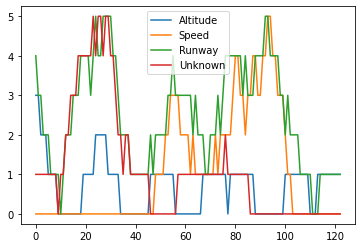

In [7]:
d_freq = frequency_of_ROI_over_time(df_data)
plt.plot(d_freq["A"], label = "Altitude")
plt.plot(d_freq["S"], label = "Speed")
plt.plot(d_freq["X"], label = "Runway")
plt.plot(d_freq["Z"], label = "Unknown")
plt.legend()

In [8]:
df_data.iloc[30:70]

,start,end,duration,x,y,roi
30,55.048477,55.404524,0.356047,846.879694,521.692394,alt
31,55.600502,56.623550,1.023048,955.571450,197.971665,runway
32,57.091571,57.337582,0.246011,659.188239,457.131588,asi
33,57.709617,61.123755,3.104136,960.942346,174.989771,runway
34,61.587792,62.137857,0.550065,677.857132,453.795808,asi
35,62.543817,63.323870,0.780053,955.077607,182.463939,runway
36,63.647870,64.169909,0.522039,660.495176,457.806283,asi
37,64.555908,66.117980,1.562072,944.836903,197.976463,runway
38,66.574002,66.940018,0.366016,841.637965,573.627460,unknown
39,67.184028,72.636286,4.998239,935.116286,192.562535,runway


In [7]:
transitions

'XAXAXAZXZXZXZXZXAZXZXZAXZXZXZXAXSXSXSXZXSXAZXSXSXZXASXSXSXSXSXSXSXAXAX'

In [9]:
def find_pos(ch, s):
    return [m.start() for m in re.finditer(ch, s)]

def create_first_order_transition_matrix(sequence):
    d = {}
    for c in sequence:
        if c in list(d.keys()):
            continue
        d_char = defaultdict(int)
        list_char_pos = find_pos(c, sequence)
        for pos in list_char_pos:
            if pos == len(sequence) - 1: # reach the end of the string
                continue
            next_char = sequence[pos + 1]
            d_char[next_char] += 1
        d[c] = d_char

    df_count = pd.DataFrame(d).reindex(columns=["A", "S", "X", "Z"]).sort_index().fillna(0)
    df_prob = df_count/df_count.sum(axis = 0)
    
    return df_count, df_prob

In [10]:
create_first_order_transition_matrix(transitions)

(     A     S     X     Z
 A  0.0   0.0   9.0   1.0
 S  1.0   0.0  12.0   0.0
 X  6.0  13.0   0.0  13.0
 Z  3.0   0.0  11.0   0.0,
      A    S        X         Z
 A  0.0  0.0  0.28125  0.071429
 S  0.1  0.0  0.37500  0.000000
 X  0.6  1.0  0.00000  0.928571
 Z  0.3  0.0  0.34375  0.000000)

In [11]:
def create_empty_matrix():
    permutations = list(itertools.product("ASXZ", repeat=3))
    good_permutations = []
    for c in permutations:
        if c[0] == c[1] or c[1] == c[2]:
            continue
        good_permutations.append(c)
        
    d = defaultdict(dict)
    for perm in good_permutations:
        first_2gram_transition = perm[0] + perm[1]
        d[first_2gram_transition][perm[2]] = 0
        
    return d

In [12]:
def create_second_order_transition_matrix(sequence):
    d = create_empty_matrix()
    processed_first_2gram_transitions = []
    for i in range(len(sequence) - 1):
        first_2gram_transition = sequence[i:i+2]
        if first_2gram_transition in processed_first_2gram_transitions: # if the 2gram is already processed, then next
            continue
        
        list_pos = find_pos(first_2gram_transition, sequence)
        for pos in list_pos:
            if pos == len(sequence) - 2: # reach the end of the string
                continue
            d[first_2gram_transition][sequence[pos + 2]] += 1
            
        processed_first_2gram_transitions.append(first_2gram_transition)
            
    df_count = (pd.DataFrame(d).sort_index())
    df_prob = (df_count/df_count.sum(axis = 0)).fillna(0)
    
    return df_count, df_prob

In [13]:
create_second_order_transition_matrix(transitions)

(    AS   AX   AZ   SA   SX   SZ   XA    XS    XZ   ZA   ZS   ZX
 A  0.0  3.0  0.0  NaN  2.0  0.0  NaN   0.0   1.0  NaN  0.0  3.0
 S  NaN  1.0  0.0  0.0  9.0  0.0  1.0   NaN   0.0  0.0  NaN  2.0
 X  1.0  NaN  3.0  0.0  NaN  0.0  5.0  12.0  10.0  1.0  0.0  NaN
 Z  0.0  1.0  NaN  0.0  2.0  NaN  3.0   0.0   NaN  0.0  0.0  8.0,
     AS   AX   AZ   SA        SX   SZ        XA   XS        XZ   ZA   ZS  \
 A  0.0  0.6  0.0  0.0  0.153846  0.0  0.000000  0.0  0.090909  0.0  0.0   
 S  0.0  0.2  0.0  0.0  0.692308  0.0  0.111111  0.0  0.000000  0.0  0.0   
 X  1.0  0.0  1.0  0.0  0.000000  0.0  0.555556  1.0  0.909091  1.0  0.0   
 Z  0.0  0.2  0.0  0.0  0.153846  0.0  0.333333  0.0  0.000000  0.0  0.0   
 
          ZX  
 A  0.230769  
 S  0.153846  
 X  0.000000  
 Z  0.615385  )

In [150]:
df_prob.fillna(0)

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,0.6,0.0,0.0,0.153846,0.0,0.000000,0.0,0.090909,0.0,0.0,0.230769
S,0.0,0.2,0.0,0.0,0.692308,0.0,0.111111,0.0,0.000000,0.0,0.0,0.153846
X,1.0,0.0,1.0,0.0,0.000000,0.0,0.555556,1.0,0.909091,1.0,0.0,0.000000
Z,0.0,0.2,0.0,0.0,0.153846,0.0,0.333333,0.0,0.000000,0.0,0.0,0.615385


In [154]:
df_count

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,3.0,0.0,NaN,2.0,0.0,NaN,0.0,1.0,NaN,0.0,3.0
S,NaN,1.0,0.0,0.0,9.0,0.0,1.0,NaN,0.0,0.0,NaN,2.0
X,1.0,NaN,3.0,0.0,NaN,0.0,5.0,12.0,10.0,1.0,0.0,NaN
Z,0.0,1.0,NaN,0.0,2.0,NaN,3.0,0.0,NaN,0.0,0.0,8.0


In [152]:
pd.DataFrame(d).sort_index().fillna(0)

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
df_count/df_count.sum(axis = 1)

,A,AS,AX,AZ,S,SA,SX,SZ,X,XA,XS,XZ,Z,ZA,ZS,ZX
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
trans_matrix = pair_transition_analysis.create_transition_count_matrix(transitions)
trans_matrix

t,A,S,X,Z
t+1,,,,
A,0,1,12,12
S,2,0,10,2
X,16,8,0,12
Z,7,5,14,0


In [188]:
trans_matrix.values.reshape(-1)

array([0.        , 0.02941176, 0.1       , 0.1       , 0.16666667,
       0.        , 0.775     , 0.2       , 0.83333333, 0.82352941,
       0.        , 0.7       , 0.        , 0.14705882, 0.125     ,
       0.        ])

In [134]:
documents = mongo.find({})
X = []
Y = []
Y2 = []
lst_pid = []
for document in documents:
    print("trial: {}, group: {}, pID: {}".format(document["trial"], document["group"], document["pID"]))
    
    d_data = document["data"]
    df_data = pd.DataFrame(d_data)
    df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
    transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")

    df_count, df_prob = create_first_order_transition_matrix(transitions)
    X.append(df_prob.values.reshape(-1))
    Y.append(document["rating"])
    Y2.append(document["rating3"])
    lst_pid.append(document["pID"])


trial: 2, group: 2, pID: 001
trial: 2, group: 2, pID: 002
trial: 2, group: 1, pID: 003
trial: 2, group: 1, pID: 004
trial: 2, group: 2, pID: 005
trial: 2, group: 2, pID: 006
trial: 2, group: 1, pID: 007
trial: 2, group: 1, pID: 008
trial: 2, group: 2, pID: 009
trial: 2, group: 1, pID: 010
trial: 2, group: 2, pID: 011
trial: 2, group: 2, pID: 014
trial: 2, group: 2, pID: 015
trial: 2, group: 2, pID: 016
trial: 2, group: 2, pID: 017
trial: 2, group: 2, pID: 019
trial: 2, group: 2, pID: 020
trial: 2, group: 2, pID: 021
trial: 2, group: 2, pID: 022
trial: 2, group: 1, pID: 023
trial: 2, group: 2, pID: 025
trial: 2, group: 2, pID: 026
trial: 2, group: 1, pID: 027
trial: 2, group: 1, pID: 029
trial: 2, group: 1, pID: 031
trial: 2, group: 1, pID: 032
trial: 1, group: 2, pID: 001
trial: 1, group: 2, pID: 002
trial: 1, group: 1, pID: 003
trial: 1, group: 1, pID: 004
trial: 1, group: 2, pID: 005
trial: 1, group: 2, pID: 006
trial: 1, group: 1, pID: 007
trial: 1, group: 1, pID: 008
trial: 1, grou

In [135]:
np.array(X).shape

(50, 16)

# Classification

In [75]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [136]:
# X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

clf = LogisticRegression(random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))
print(classification_report(y_pred, y_test))

0.6
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       0.53      0.73      0.62        11

    accuracy                           0.60        25
   macro avg       0.62      0.61      0.60        25
weighted avg       0.63      0.60      0.60        25



In [137]:
clf = SVC(kernel='linear', C=0.025, random_state=3)
scores = cross_val_score(clf, X, Y, cv=4, scoring = "accuracy")
scores

array([0.53846154, 0.53846154, 0.58333333, 0.5       ])

In [138]:
h = .02  # step size in the mesh

names = ["Logistic Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(random_state=1),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [139]:
i = 1
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    
    if hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]

    thresh = 0.5

    pred = []
    for v in y_score:
        if v > thresh:
            pred.append(1)
        else:
            pred.append(0)

    print(name)
    print("AUC: ", roc_auc_score(y_test, y_score))
    target_names = ['group 1', 'group 2']
    print(classification_report(y_test, pred, target_names=target_names))

Logistic Regression
AUC:  0.7
              precision    recall  f1-score   support

     group 1       0.45      1.00      0.62        10
     group 2       1.00      0.20      0.33        15

    accuracy                           0.52        25
   macro avg       0.73      0.60      0.48        25
weighted avg       0.78      0.52      0.45        25

Nearest Neighbors
AUC:  0.72
              precision    recall  f1-score   support

     group 1       0.54      0.70      0.61        10
     group 2       0.75      0.60      0.67        15

    accuracy                           0.64        25
   macro avg       0.64      0.65      0.64        25
weighted avg       0.67      0.64      0.64        25

Linear SVM
AUC:  0.7
              precision    recall  f1-score   support

     group 1       0.40      1.00      0.57        10
     group 2       0.00      0.00      0.00        15

    accuracy                           0.40        25
   macro avg       0.20      0.50      0.29     

c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net
AUC:  0.6866666666666666
              precision    recall  f1-score   support

     group 1       0.46      0.60      0.52        10
     group 2       0.67      0.53      0.59        15

    accuracy                           0.56        25
   macro avg       0.56      0.57      0.56        25
weighted avg       0.58      0.56      0.56        25

AdaBoost
AUC:  0.6633333333333332
              precision    recall  f1-score   support

     group 1       0.47      0.80      0.59        10
     group 2       0.75      0.40      0.52        15

    accuracy                           0.56        25
   macro avg       0.61      0.60      0.56        25
weighted avg       0.64      0.56      0.55        25

Naive Bayes
AUC:  0.6666666666666667
              precision    recall  f1-score   support

     group 1       0.55      0.60      0.57        10
     group 2       0.71      0.67      0.69        15

    accuracy                           0.64        25
   macro avg       0.

c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [140]:
# Good/Bad
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X, Y, cv=4, scoring = "accuracy")
    print(f"{name}:{scores}")

Logistic Regression:[0.84615385 0.61538462 0.5        0.5       ]
Nearest Neighbors:[0.46153846 0.69230769 0.58333333 0.33333333]
Linear SVM:[0.53846154 0.53846154 0.58333333 0.5       ]
RBF SVM:[0.84615385 0.69230769 0.58333333 0.5       ]
Gaussian Process:[0.53846154 0.69230769 0.5        0.5       ]
Decision Tree:[0.61538462 0.53846154 0.41666667 0.58333333]
Random Forest:[0.76923077 0.61538462 0.58333333 0.58333333]
Neural Net:[0.92307692 0.61538462 0.5        0.5       ]
AdaBoost:[0.53846154 0.61538462 0.58333333 0.58333333]
Naive Bayes:[0.69230769 0.69230769 0.66666667 0.58333333]
QDA:[0.46153846 0.46153846 0.41666667 0.5       ]


c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning

In [141]:
# Good/Medium/Bad
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X, Y2, cv=4, scoring = "accuracy")
    print(f"{name}:{scores}")

Logistic Regression:[0.76923077 0.30769231 0.33333333 0.5       ]
Nearest Neighbors:[0.61538462 0.61538462 0.41666667 0.08333333]
Linear SVM:[0.46153846 0.46153846 0.41666667 0.41666667]
RBF SVM:[0.53846154 0.46153846 0.5        0.25      ]
Gaussian Process:[0.46153846 0.46153846 0.5        0.25      ]
Decision Tree:[0.46153846 0.38461538 0.16666667 0.41666667]
Random Forest:[0.46153846 0.53846154 0.33333333 0.41666667]
Neural Net:[0.61538462 0.30769231 0.41666667 0.25      ]
AdaBoost:[0.38461538 0.46153846 0.16666667 0.33333333]
Naive Bayes:[0.46153846 0.46153846 0.5        0.5       ]
QDA:[0.46153846 0.46153846 0.41666667 0.41666667]


c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning

# Clustering

In [142]:
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

In [143]:
# k-means clustering
model = KMeans(n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
print("k-means")
print(classification_report(Y, yhat))

k-means
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.67      0.59      0.63        27

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.63      0.62      0.62        50



In [144]:
# AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2)
# fit the model
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
print("AgglomerativeClustering")
print(classification_report(Y, yhat))

AgglomerativeClustering
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        23
           1       0.42      0.41      0.42        27

    accuracy                           0.38        50
   macro avg       0.38      0.38      0.38        50
weighted avg       0.38      0.38      0.38        50



In [145]:
# GaussianMixture
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
print("GaussianMixture")
print(classification_report(Y, yhat))

GaussianMixture
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.67      0.59      0.63        27

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.63      0.62      0.62        50



In [146]:
# Birch
model = Birch(threshold=0.01, n_clusters=2)
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
print("Birch")
print(classification_report(Y, yhat))

Birch
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        23
           1       0.42      0.41      0.42        27

    accuracy                           0.38        50
   macro avg       0.38      0.38      0.38        50
weighted avg       0.38      0.38      0.38        50



In [147]:
# DBSCAN
model = DBSCAN(eps=0.3, min_samples=8)
# fit model and predict clusters
yhat = model.fit_predict(X)
print("DBSCAN")
print(classification_report(Y, yhat))

DBSCAN
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00      23.0
           1       0.00      0.00      0.00      27.0

    accuracy                           0.00      50.0
   macro avg       0.00      0.00      0.00      50.0
weighted avg       0.00      0.00      0.00      50.0



c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\work\Anaconda3\envs\kia\lib\si

In [148]:
#MiniBatchKMeans
# define the model
model = MiniBatchKMeans(n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
print("MiniBatchKMeans")
print(classification_report(Y, yhat))

MiniBatchKMeans
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        23
           1       0.42      0.41      0.42        27

    accuracy                           0.38        50
   macro avg       0.38      0.38      0.38        50
weighted avg       0.38      0.38      0.38        50



## distance matrix from transition matrix

In [149]:
from scipy.spatial import distance_matrix
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [150]:
dist_matrix = distance_matrix(X, X)

In [89]:
dist_array = ssd.squareform(dist_matrix)

In [90]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.624269,0.691432,0.566509,0.724713,0.667435,0.686364,1.218226,0.787707,0.746067,...,0.627237,0.614745,0.623235,0.666773,0.794428,0.653769,0.793309,0.624693,0.608447,0.714103
1,0.624269,0.000000,0.317155,0.533405,0.997199,0.320943,0.448883,1.115515,0.657898,0.599372,...,0.674631,0.448740,0.475282,0.460804,1.015523,0.875904,0.565014,0.267115,0.657238,0.717369
2,0.691432,0.317155,0.000000,0.493188,0.898904,0.543295,0.664483,0.877136,0.638529,0.566376,...,0.726348,0.570307,0.609349,0.613596,0.861419,0.754155,0.786211,0.377700,0.714640,0.856135
3,0.566509,0.533405,0.493188,0.000000,0.904073,0.651509,0.643590,0.934682,0.390686,0.446541,...,0.655025,0.675235,0.686261,0.747532,0.895254,0.617967,0.816857,0.582196,0.425982,0.849277
4,0.724713,0.997199,0.898904,0.904073,0.000000,1.023312,1.074529,1.007489,1.211536,0.838515,...,0.779343,1.050093,1.124369,1.144801,0.706588,0.756453,1.354221,0.930322,1.020507,1.106047
5,0.667435,0.320943,0.543295,0.651509,1.023312,0.000000,0.344050,1.294554,0.722150,0.710025,...,0.484502,0.452015,0.383152,0.390015,1.212402,1.077588,0.458788,0.316710,0.753399,0.470562
6,0.686364,0.448883,0.664483,0.643590,1.074529,0.344050,0.000000,1.379822,0.758027,0.705753,...,0.575195,0.470074,0.557709,0.470174,1.256866,1.054691,0.563236,0.406780,0.753138,0.566345
7,1.218226,1.115515,0.877136,0.934682,1.007489,1.294554,1.379822,0.000000,1.104585,0.780824,...,1.253808,1.330307,1.382577,1.430777,0.905217,0.870977,1.547300,1.190174,1.127938,1.559136
8,0.787707,0.657898,0.638529,0.390686,1.211536,0.722150,0.758027,1.104585,0.000000,0.703859,...,0.785581,0.731097,0.627882,0.727340,1.182854,0.933922,0.698397,0.725457,0.612910,0.838610
9,0.746067,0.599372,0.566376,0.446541,0.838515,0.710025,0.705753,0.780824,0.703859,0.000000,...,0.708173,0.876528,0.903100,0.923765,0.906685,0.751948,0.996733,0.652181,0.543163,0.997496


In [91]:
condensed_dist_matrix = ssd.squareform(dist_matrix)
condensed_dist_matrix.shape

(1225,)

In [92]:
condensed_dist_matrix

array([0.62426867, 0.69143181, 0.56650945, ..., 0.68166125, 0.60108447,
       0.9185349 ])

In [93]:
plt.rcParams.update({'font.size': 22})

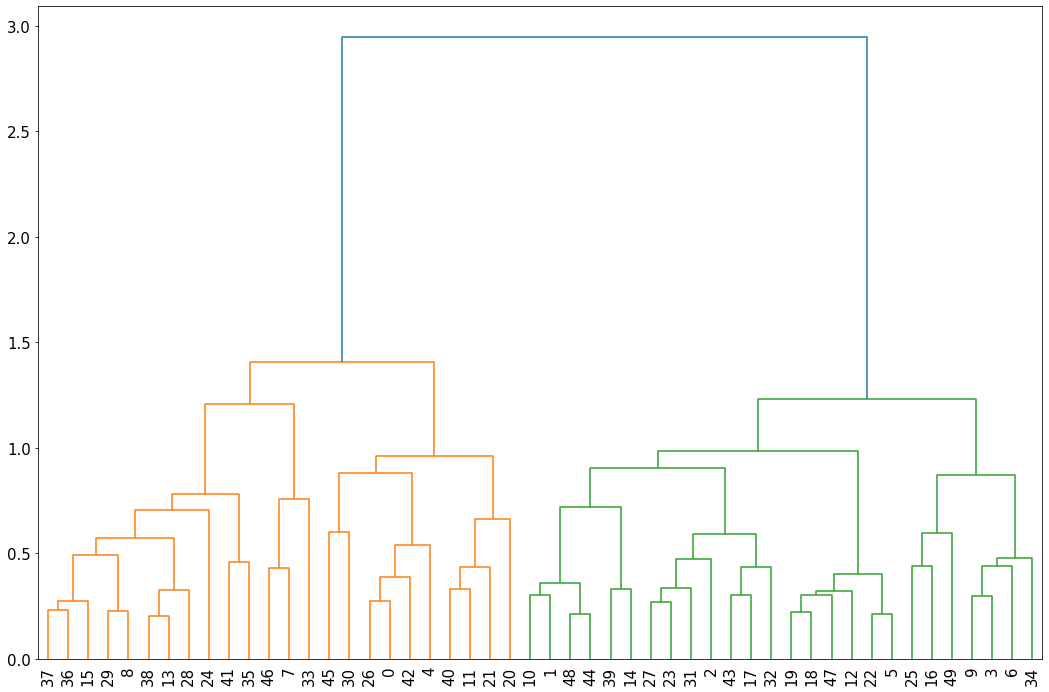

In [151]:
linked = linkage(X, 'ward')

plt.figure(figsize=(18, 12))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            # labels = [f"{pid}-{y}-{y2}" for pid, y, y2,  in zip(lst_pid,Y,Y2)],
            show_leaf_counts=True)

plt.tick_params(axis='both', which='major', labelsize=15)
xticks = plt.xticks()
plt.show()

In [152]:
l = [int(v.get_text()) for v in xticks[1]]
labels = [f"{lst_pid[i]}-{y}-{y2}" for i, y, y2 in zip(l, Y, Y2)]

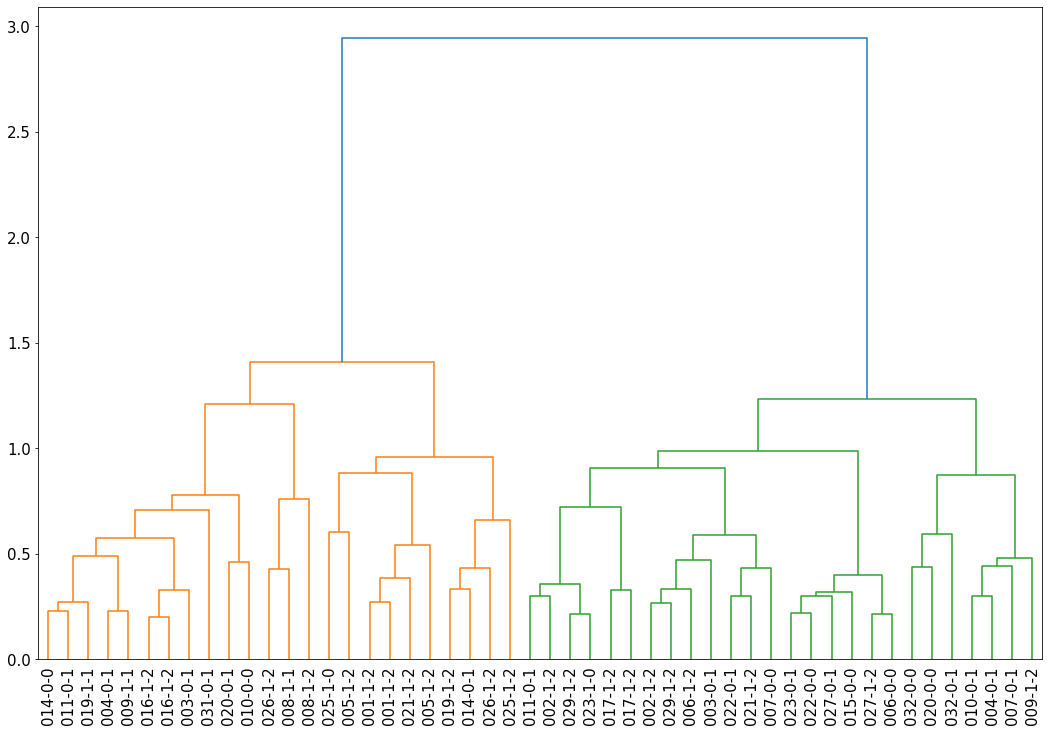

In [162]:
plt.figure(figsize=(18, 12))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            labels = [f"{pid}-{y}-{y2}" for pid, y, y2 in zip(lst_pid,Y,Y2)],
            show_leaf_counts=True)

plt.tick_params(axis='both', which='major', labelsize=15)
xticks = plt.xticks()
plt.show()

In [157]:
np.array(Y)

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0])

In [158]:
predY - np.array(Y)

array([ 0, -1,  0,  1,  0, -1,  0,  0, -1,  0,  1,  1, -1, -1, -1,  0, -1,
        0,  0,  0,  0,  0, -1,  1, -1, -1,  1,  1,  0,  0,  1,  0, -1,  0,
        0,  1,  0, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1,  1,  0],
      dtype=int64)

In [166]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
predY = cluster.fit_predict(dist_matrix)
print(classification_report(Y, predY))

              precision    recall  f1-score   support

           0       0.48      0.64      0.55        25
           1       0.47      0.32      0.38        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.47        50
weighted avg       0.48      0.48      0.47        50



c:\users\work\anaconda3\envs\kia\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
